In [1]:
import os, shutil
shutil.copy(os.path.join('../input/convnext-roberta-final-v1-20epochs/convnextroberta20.pt'), os.path.join('/kaggle/working/'))

'/kaggle/working/convnextroberta20.pt'

In [2]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.7/548.7 kB 8.7 MB/s eta 0:00:00


In [3]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [4]:
class CFG:
    debug = False
    captions_path = "."
    batch_size = 32
    num_workers = 2
    head_lr = 1e-3
    image_encoder_lr = 1e-5
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #model_name = 'vit_base_patch32_224_in21k'
    model_name = 'convnext_base_in22ft1k'
    image_embedding = 1024
    text_encoder_model = "roberta-base"
    text_embedding = 768
    text_tokenizer = "roberta-base"
    max_length = 200

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256 
    dropout = 0.1

## Image Encoder

In [5]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0,
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

## Text Encoder

In [6]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = RobertaModel.from_pretrained(model_name)
        else:
            self.model = RobertaModel(config=RobertaConfig())
            
        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

## Projection Head

In [7]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

## CLIP

In [8]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [9]:
def get_model(model_path):
    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    return model
model = get_model("convnextroberta20.pt")
print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_base_22k_1k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_base_22k_1k_224.pth


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model parameters: 212,803,968


#  ****EXEMPLE 1****
# 

In [10]:
! pip install ftfy regex tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.7 MB/s eta 0:00:00


In [11]:
import torch
from PIL import Image

In [12]:
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image

preprocess = Compose([
    Resize(CFG.size, interpolation=Image.BICUBIC),
    CenterCrop(CFG.size),
    ToTensor()
])
image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).cuda()
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).cuda()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  """
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [13]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from pkg_resources import packaging

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse", 
    "coffee": "a cup of coffee on a saucer"
}

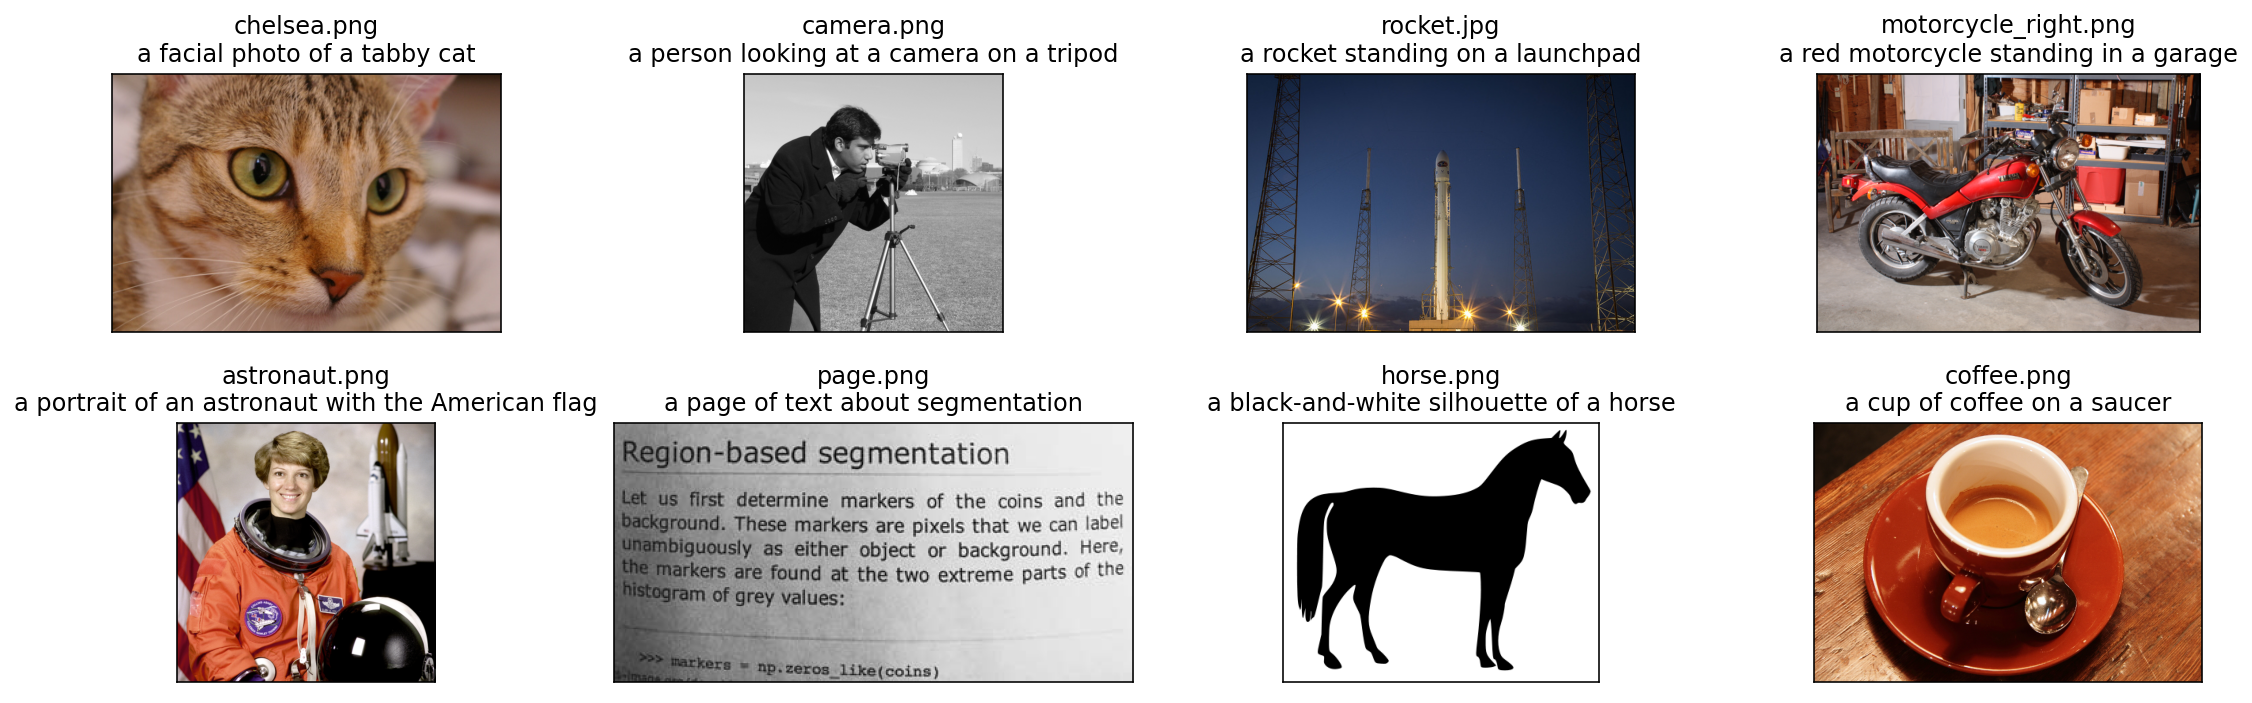

In [14]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
  
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()

In [15]:
image_input = torch.tensor(np.stack(images)).cuda()

In [16]:
loader = torch.utils.data.DataLoader(images)
with torch.no_grad():
    image_features_1=[]
    for i, imge in enumerate(tqdm(loader)):
        imge = imge.cuda()
        image_features = model.image_encoder(imge.to(CFG.device))
        image_features = model.image_projection(image_features)
        image_features = F.normalize(image_features, p=2, dim=-1)
        image_features = image_features.mean(dim=0)
        image_features /= image_features.norm()
        image_features_1.append(image_features)
    image_features_1 = torch.stack(image_features_1, dim=1).cuda()


  0%|          | 0/8 [00:00<?, ?it/s]

In [17]:
from torchvision.datasets import CIFAR100
cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


In [18]:
with torch.no_grad():
    zeroshot_weights = []
    for label in tqdm(cifar100.classes):
        texts = [f"This is a photo of a {label}"] #format with class
        tokenizer = RobertaTokenizer.from_pretrained(CFG.text_tokenizer)
        texts_2 = tokenizer(texts, padding=True, truncation=True, max_length=CFG.max_length)
        batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in texts_2.items()
    }
        text_features = model.text_encoder( 
        input_ids=batch["input_ids"], attention_mask=batch["attention_mask"] )
        text_embeddings = model.text_projection(text_features) #embed with text encoder  
        class_embeddings = F.normalize(text_embeddings, p=2, dim=-1)
        class_embedding = class_embeddings.mean(dim=0)
        zeroshot_weights.append(class_embedding)
    zeroshot_weights_2 = torch.stack(zeroshot_weights, dim=1).cuda()

  0%|          | 0/100 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

In [19]:
text_probs = (100.0 * image_features_1.T @ zeroshot_weights_2).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

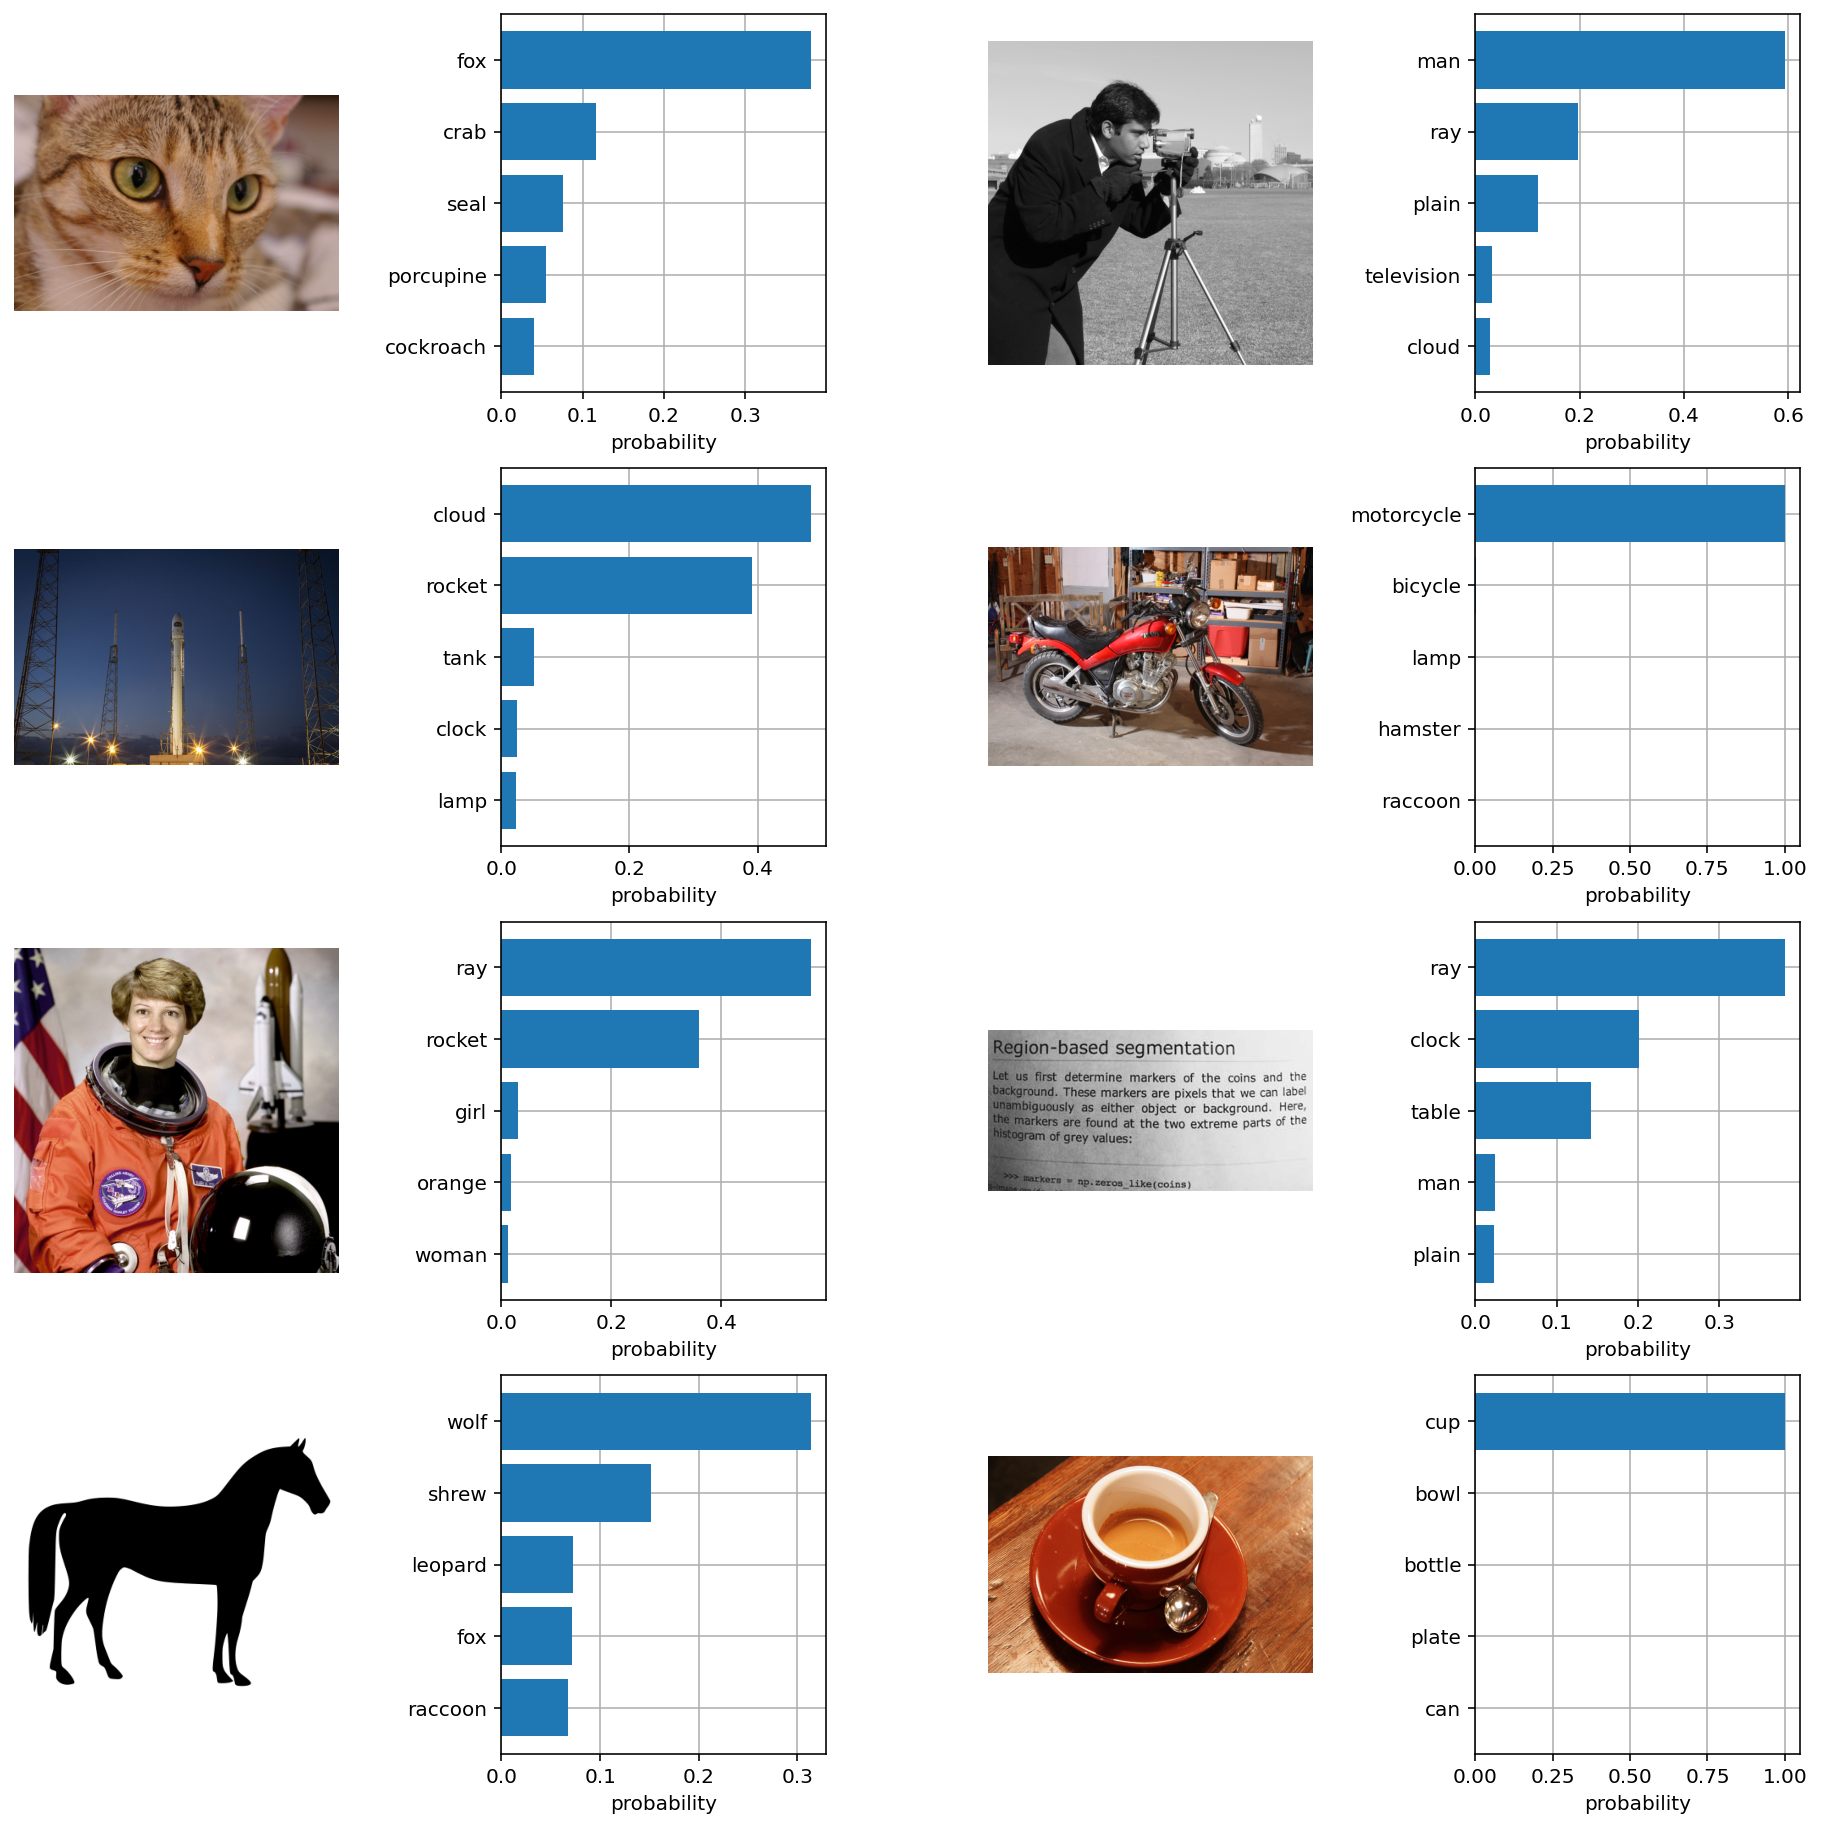

In [20]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)

plt.savefig('test1.png')

In [21]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [22]:
# Store the preprocessed images in a list
images_chi_or_muf = []
texts_chi_or_muf = []

for filename in [filename for filename in os.listdir('../input/dogdoddog/deep-learning-datasets-master/chihuahua-muffin') if filename.endswith(".jpeg") or filename.endswith(".jpg")]:
    name = filename.split('-')[0]
    image = preprocess(Image.open(os.path.join('../input/dogdoddog/deep-learning-datasets-master/chihuahua-muffin', filename)).convert("RGB"))
    images_chi_or_muf.append(image)
    texts_chi_or_muf.append(name)

In [23]:
image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).cuda()
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).cuda()
image_input_chi_or_muf = torch.tensor(np.stack(images_chi_or_muf)).cuda()
image_input_chi_or_muf -= image_mean[:, None, None]
image_input_chi_or_muf /= image_std[:, None, None]


In [24]:
loader = torch.utils.data.DataLoader(image_input_chi_or_muf)
with torch.no_grad():
    image_features_1=[]
    for i, imge in enumerate(tqdm(loader)):
        imge = imge.cuda()
        image_features = model.image_encoder(imge.to(CFG.device))
        image_features = model.image_projection(image_features)
        image_features = F.normalize(image_features, p=2, dim=-1)
        image_features = image_features.mean(dim=0)
        image_features /= image_features.norm()
        image_features_1.append(image_features)
    image_features_1 = torch.stack(image_features_1, dim=1).cuda()

  0%|          | 0/17 [00:00<?, ?it/s]

In [25]:
classes = ['chihuahua','muffin']

In [26]:
with torch.no_grad():
    zeroshot_weights = []
    for label in tqdm(classes):
        texts = [f"This is a photo of a {label}"] #format with class
        tokenizer = RobertaTokenizer.from_pretrained(CFG.text_tokenizer)
        texts_2 = tokenizer(texts, padding=True, truncation=True, max_length=CFG.max_length)
        batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in texts_2.items()
    }
        text_features = model.text_encoder( 
        input_ids=batch["input_ids"], attention_mask=batch["attention_mask"] )
        text_embeddings = model.text_projection(text_features) #embed with text encoder  
        class_embeddings = F.normalize(text_embeddings, p=2, dim=-1)
        class_embedding = class_embeddings.mean(dim=0)
        zeroshot_weights.append(class_embedding)
    zeroshot_weights_2 = torch.stack(zeroshot_weights, dim=1).cuda()

  0%|          | 0/2 [00:00<?, ?it/s]

In [27]:
text_probs = (100.0 * image_features_1.T @ zeroshot_weights_2).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(2, dim=-1)

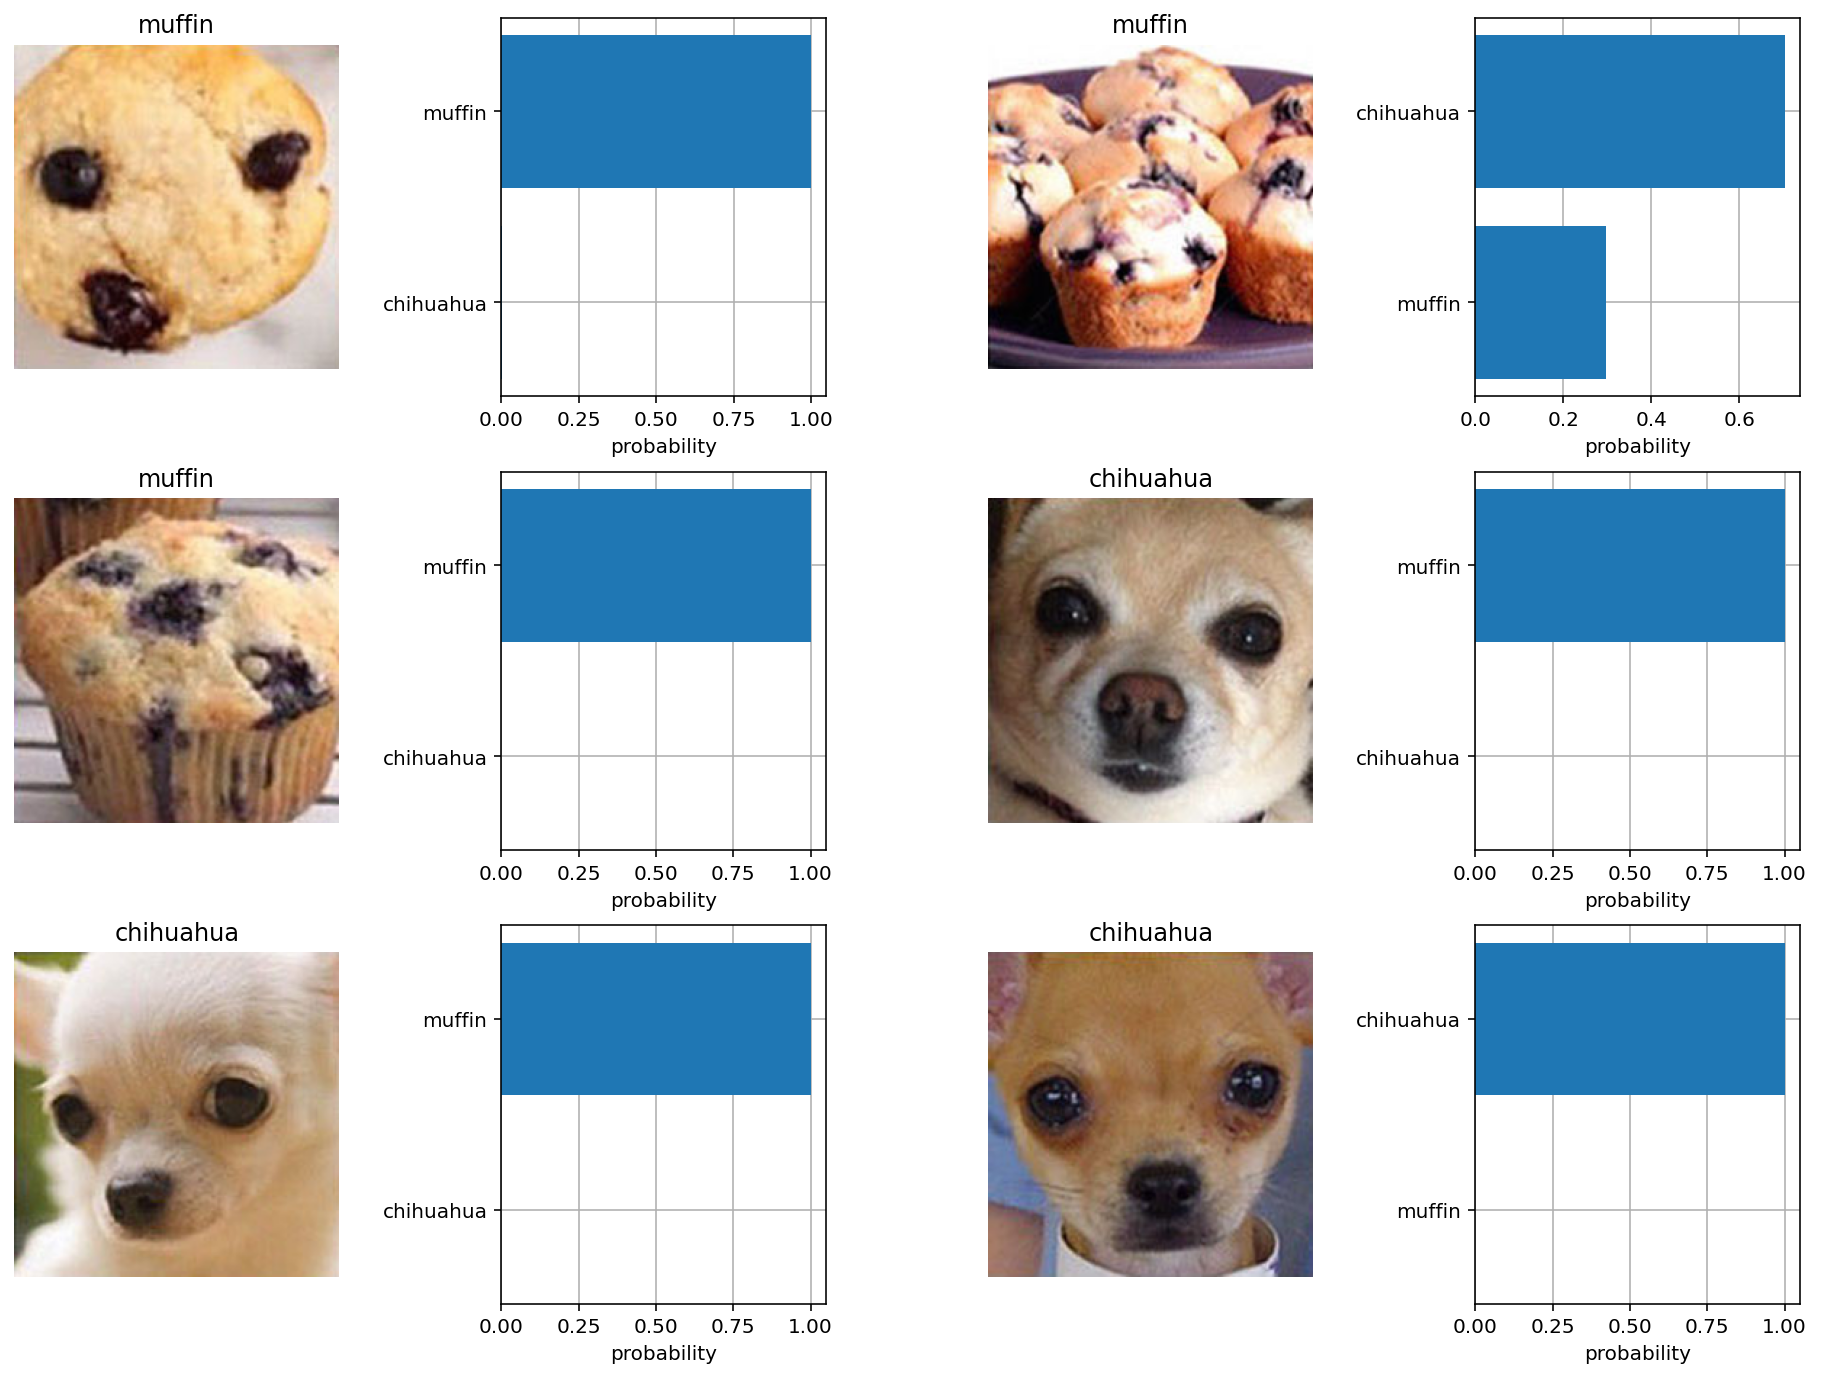

In [28]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(images_chi_or_muf[2:8]):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.axis("off")
    plt.title(texts_chi_or_muf[i+2])

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.savefig('testhotdog5.png')

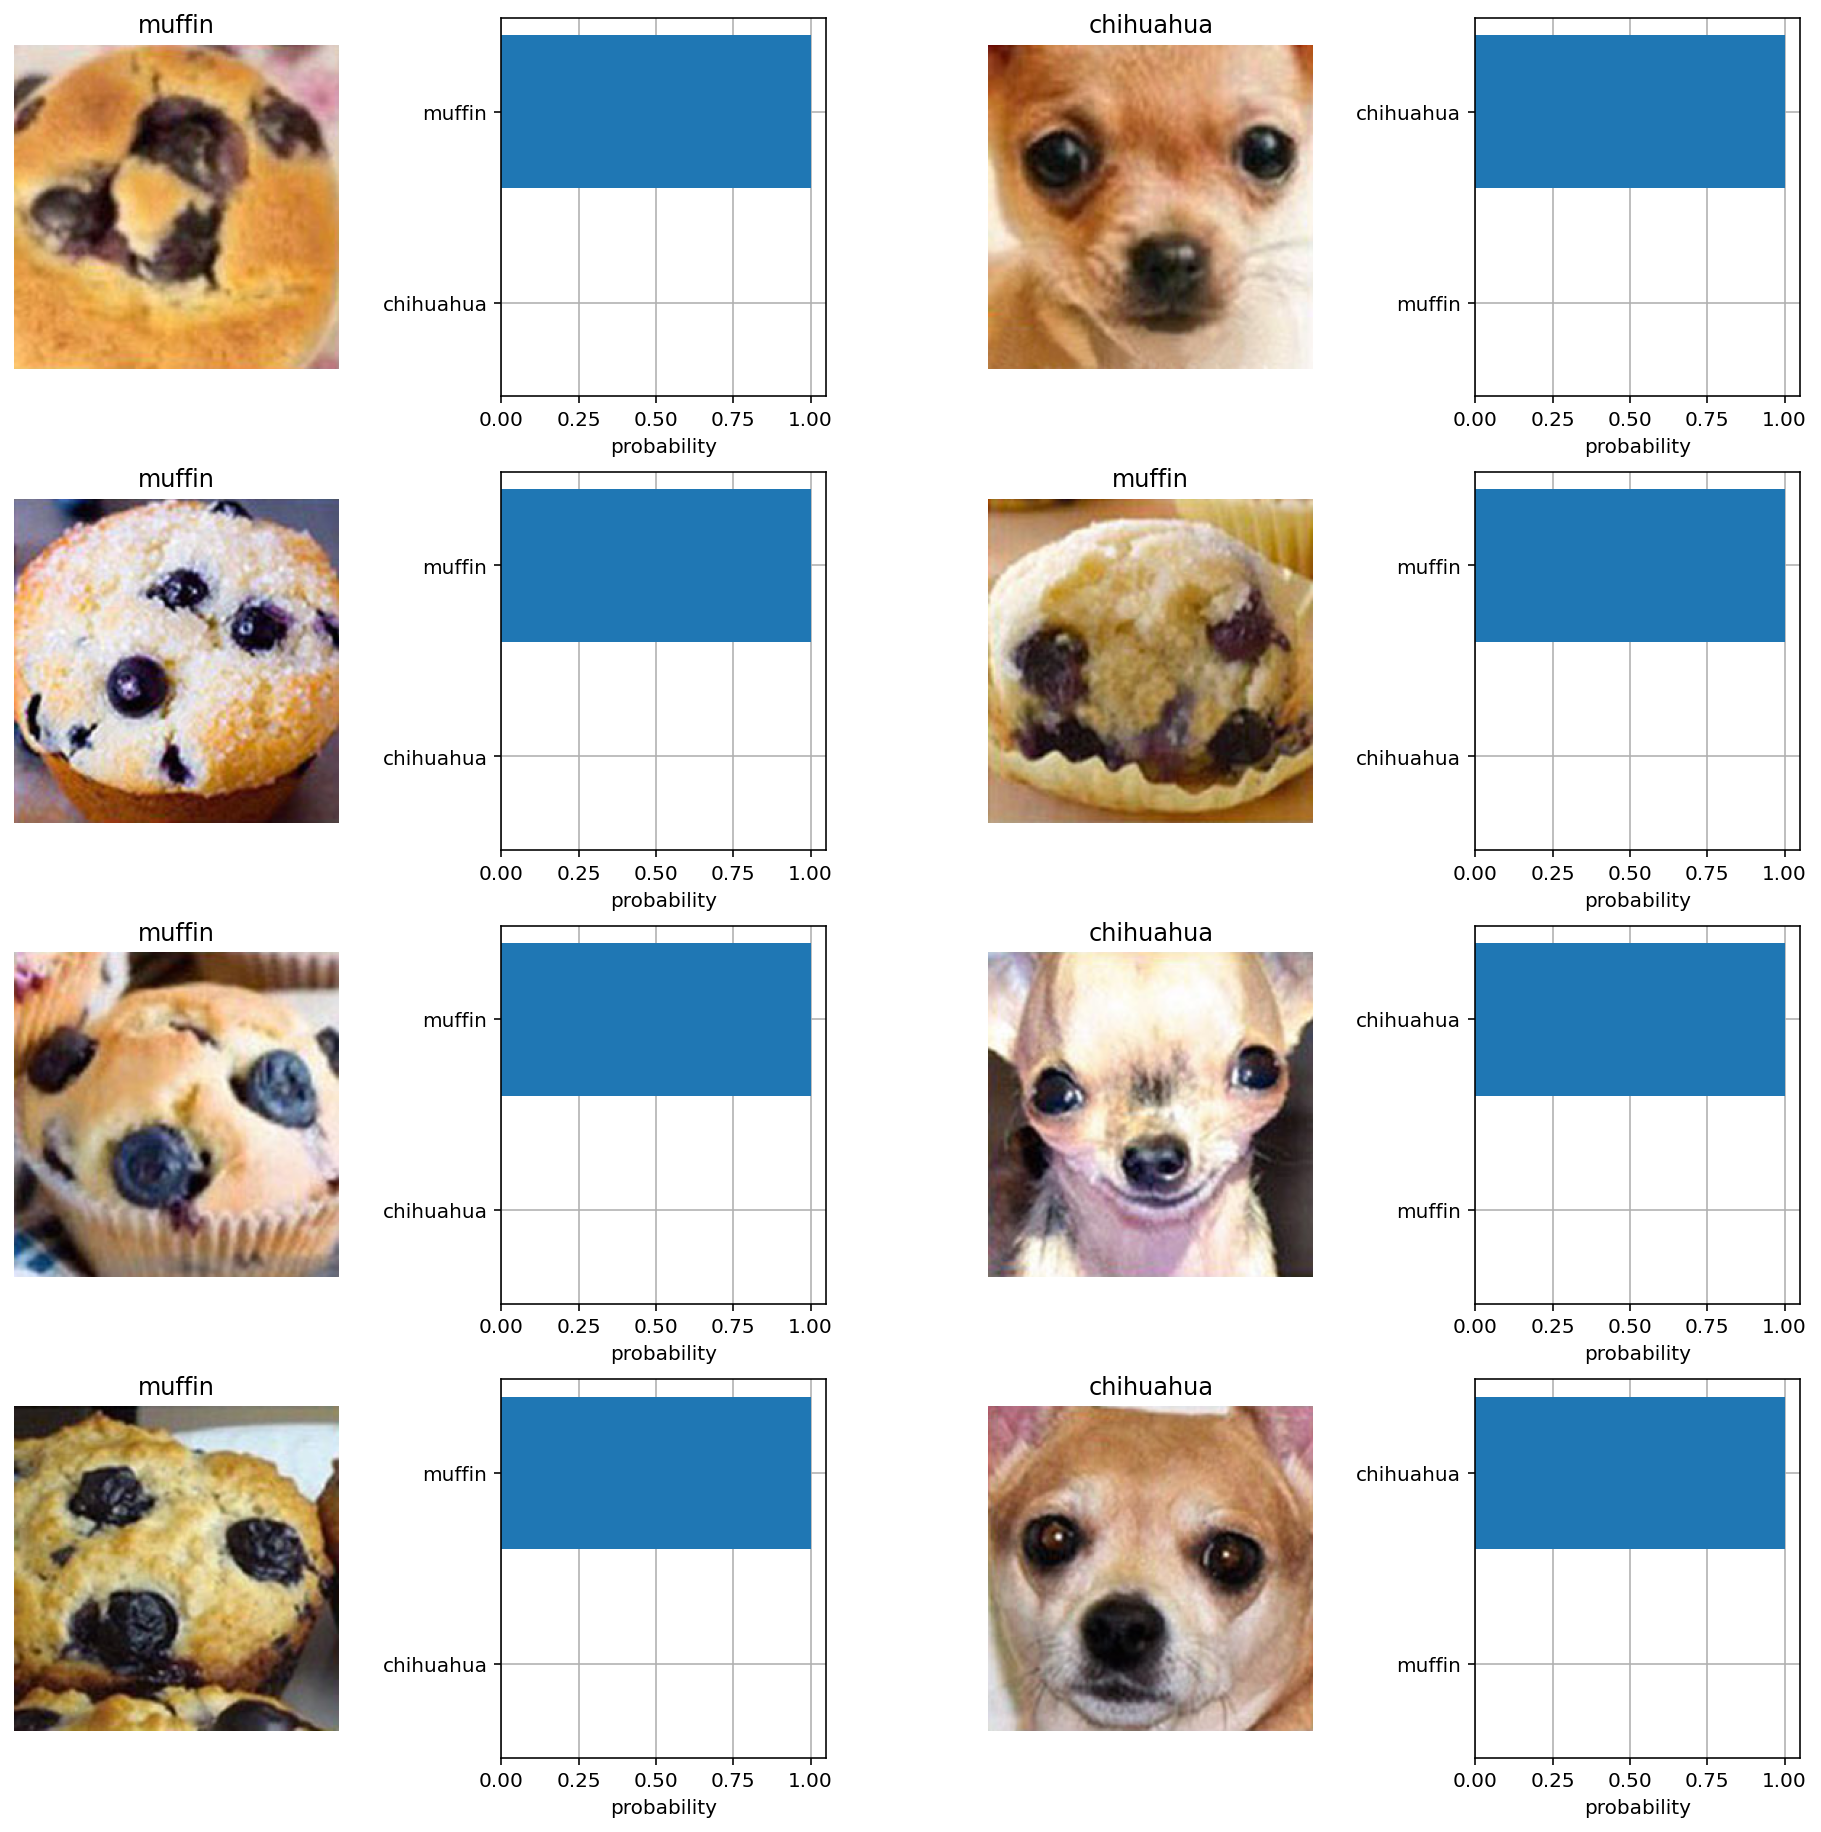

In [29]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(images_chi_or_muf[8:16]):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.axis("off")
    plt.title(texts_chi_or_muf[i + 8])

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i + 8])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [classes[index] for index in top_labels[i + 8].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.savefig('testhotdog4.png')

In [30]:
images_pup_or_bag = []
texts_pup_or_bag = []
    
for filename in [filename for filename in os.listdir('../input/dogdoddog/deep-learning-datasets-master/dog-bagel') if filename.endswith(".jpeg") or filename.endswith(".jpg")]:
    name = filename.split('-')[0]
    image = preprocess(Image.open(os.path.join('../input/dogdoddog/deep-learning-datasets-master/dog-bagel', filename)).convert("RGB"))
    images_pup_or_bag.append(image)
    texts_pup_or_bag.append(name)

In [31]:
image_input_pup_or_bag = torch.tensor(np.stack(images_pup_or_bag)).cuda()
image_input_pup_or_bag -= image_mean[:, None, None]
image_input_pup_or_bag /= image_std[:, None, None]

In [32]:
loader = torch.utils.data.DataLoader(images_pup_or_bag)
with torch.no_grad():
    image_features_1=[]
    for i, imge in enumerate(tqdm(loader)):
        imge = imge.cuda()
        image_features = model.image_encoder(imge.to(CFG.device))
        image_features = model.image_projection(image_features)
        image_features = F.normalize(image_features, p=2, dim=-1)
        image_features = image_features.mean(dim=0)
        image_features /= image_features.norm()
        image_features_1.append(image_features)
    image_features_1 = torch.stack(image_features_1, dim=1).cuda()

  0%|          | 0/17 [00:00<?, ?it/s]

In [33]:
classes = ['puppy','bagel']

In [34]:
with torch.no_grad():
    zeroshot_weights = []
    for label in tqdm(classes):
        texts = [f"This is a photo of a {label}"] #format with class
        tokenizer = RobertaTokenizer.from_pretrained(CFG.text_tokenizer)
        texts_2 = tokenizer(texts, padding=True, truncation=True, max_length=CFG.max_length)
        batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in texts_2.items()
    }
        text_features = model.text_encoder( 
        input_ids=batch["input_ids"], attention_mask=batch["attention_mask"] )
        text_embeddings = model.text_projection(text_features) #embed with text encoder  
        class_embeddings = F.normalize(text_embeddings, p=2, dim=-1)
        class_embedding = class_embeddings.mean(dim=0)
        zeroshot_weights.append(class_embedding)
    zeroshot_weights_2 = torch.stack(zeroshot_weights, dim=1).cuda()

  0%|          | 0/2 [00:00<?, ?it/s]

In [35]:
text_probs = (100.0 * image_features_1.T @ zeroshot_weights_2).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(2, dim=-1)

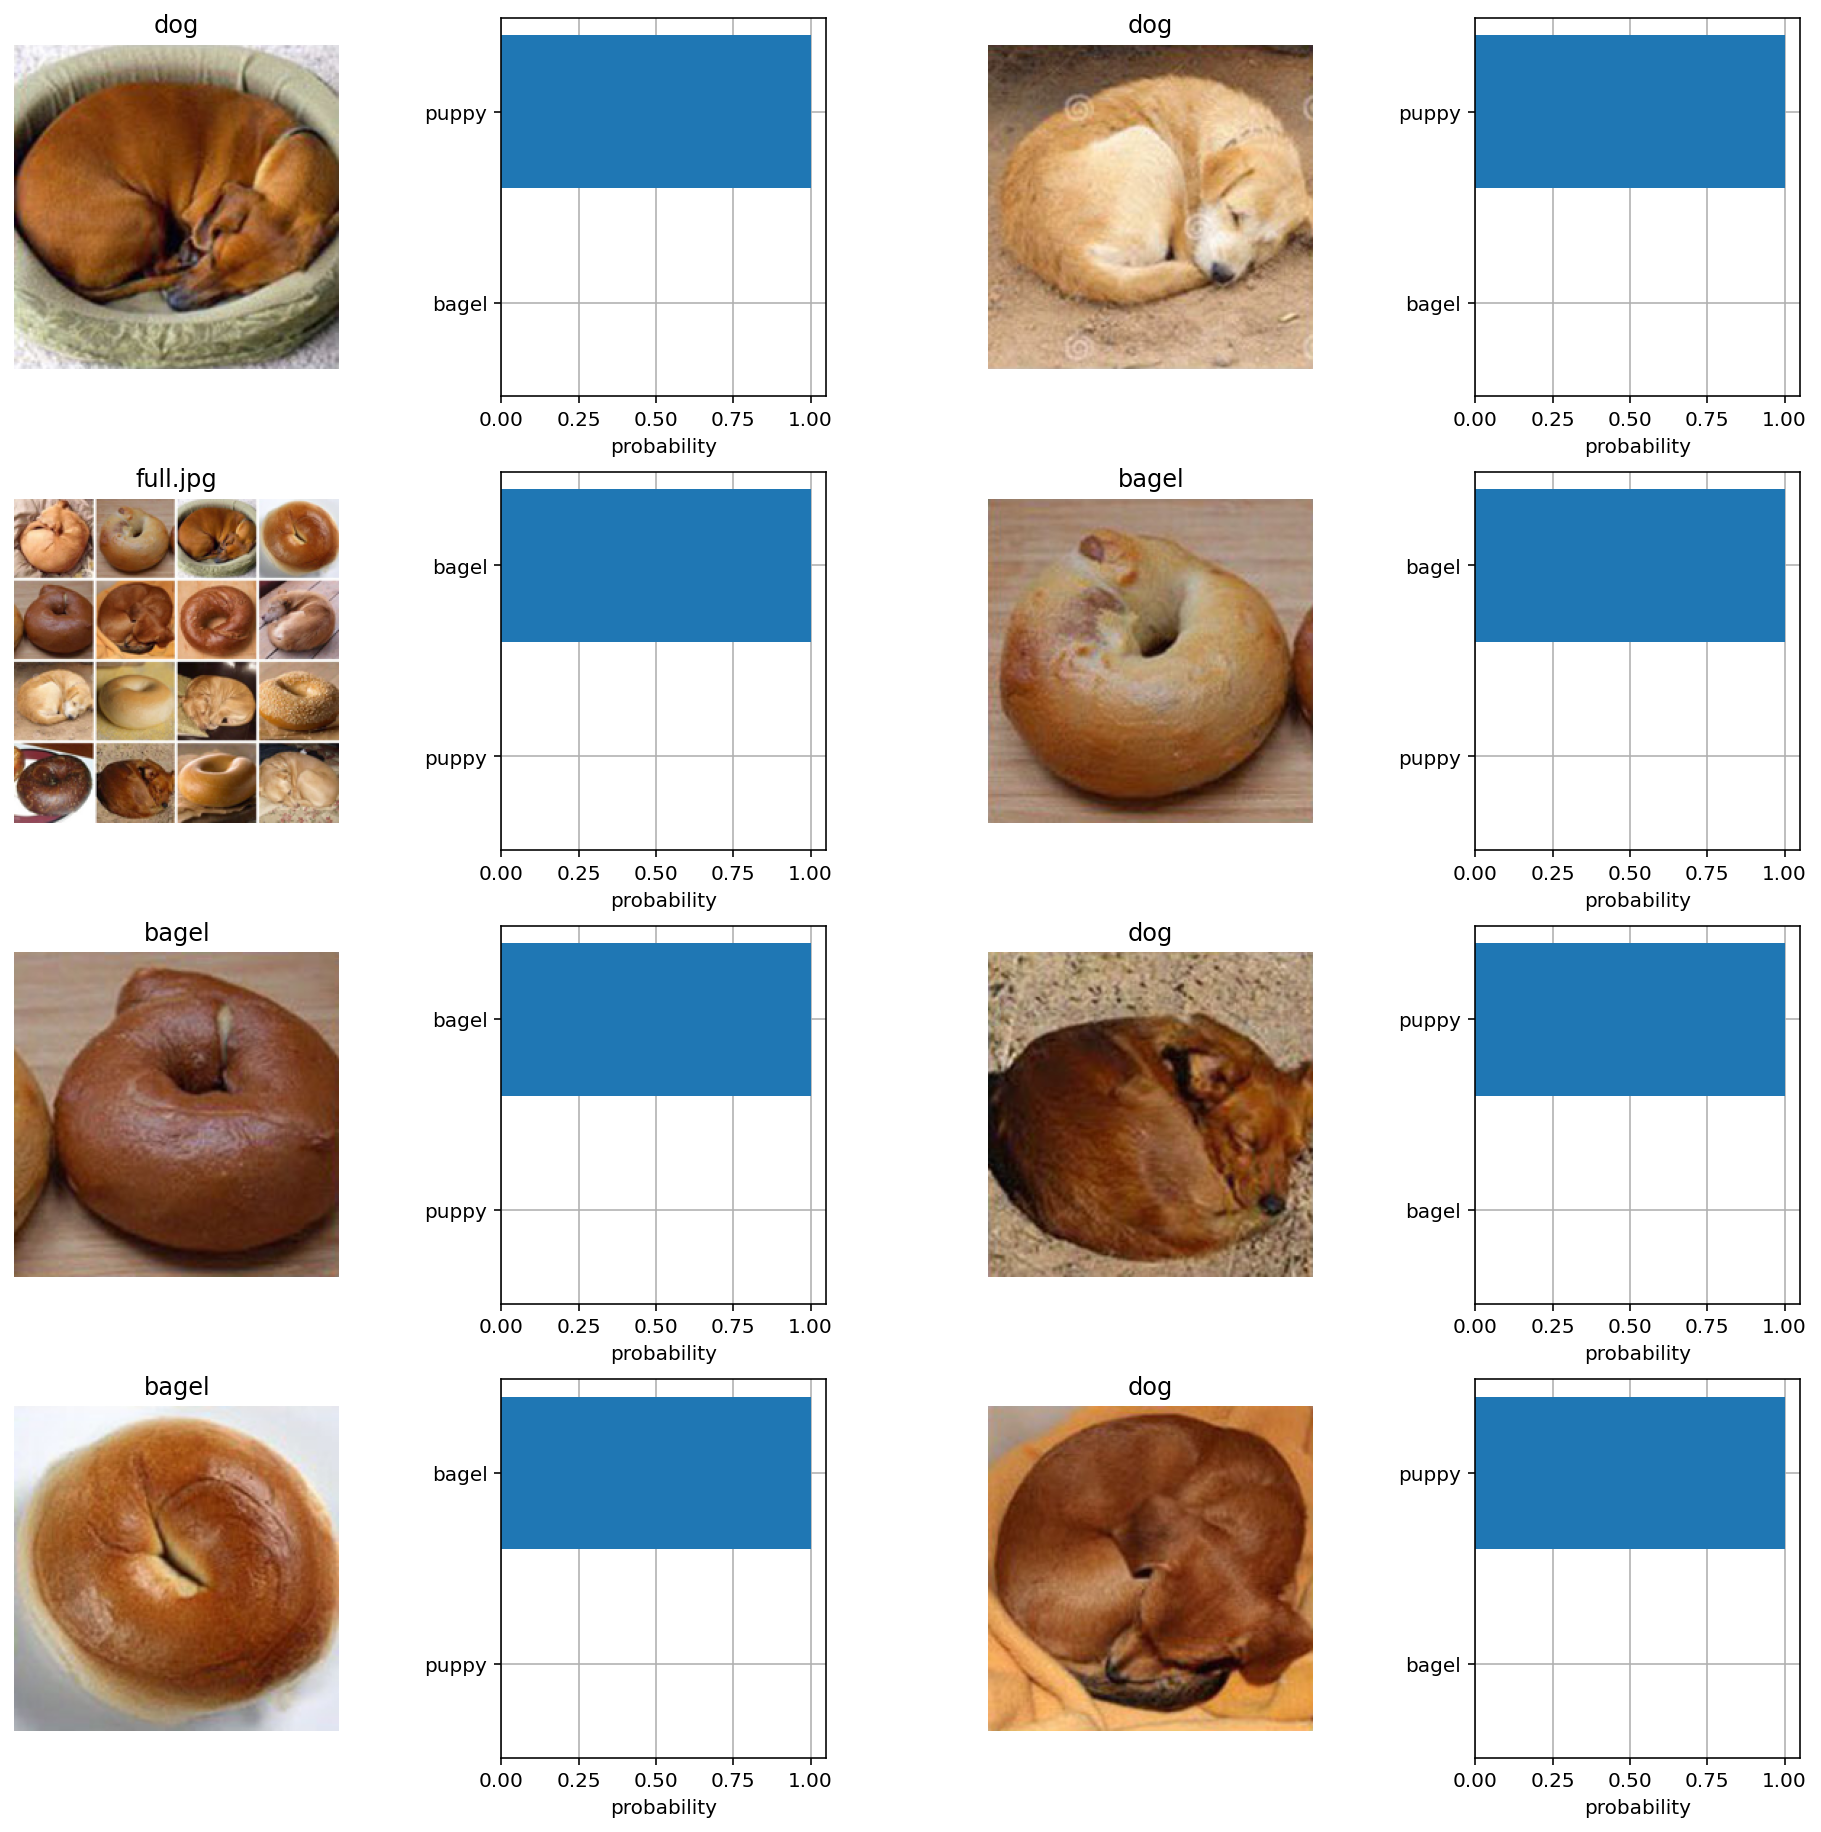

In [36]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(images_pup_or_bag[:8]):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.axis("off")
    plt.title(texts_pup_or_bag[i])

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.savefig('testhotdog6.png')

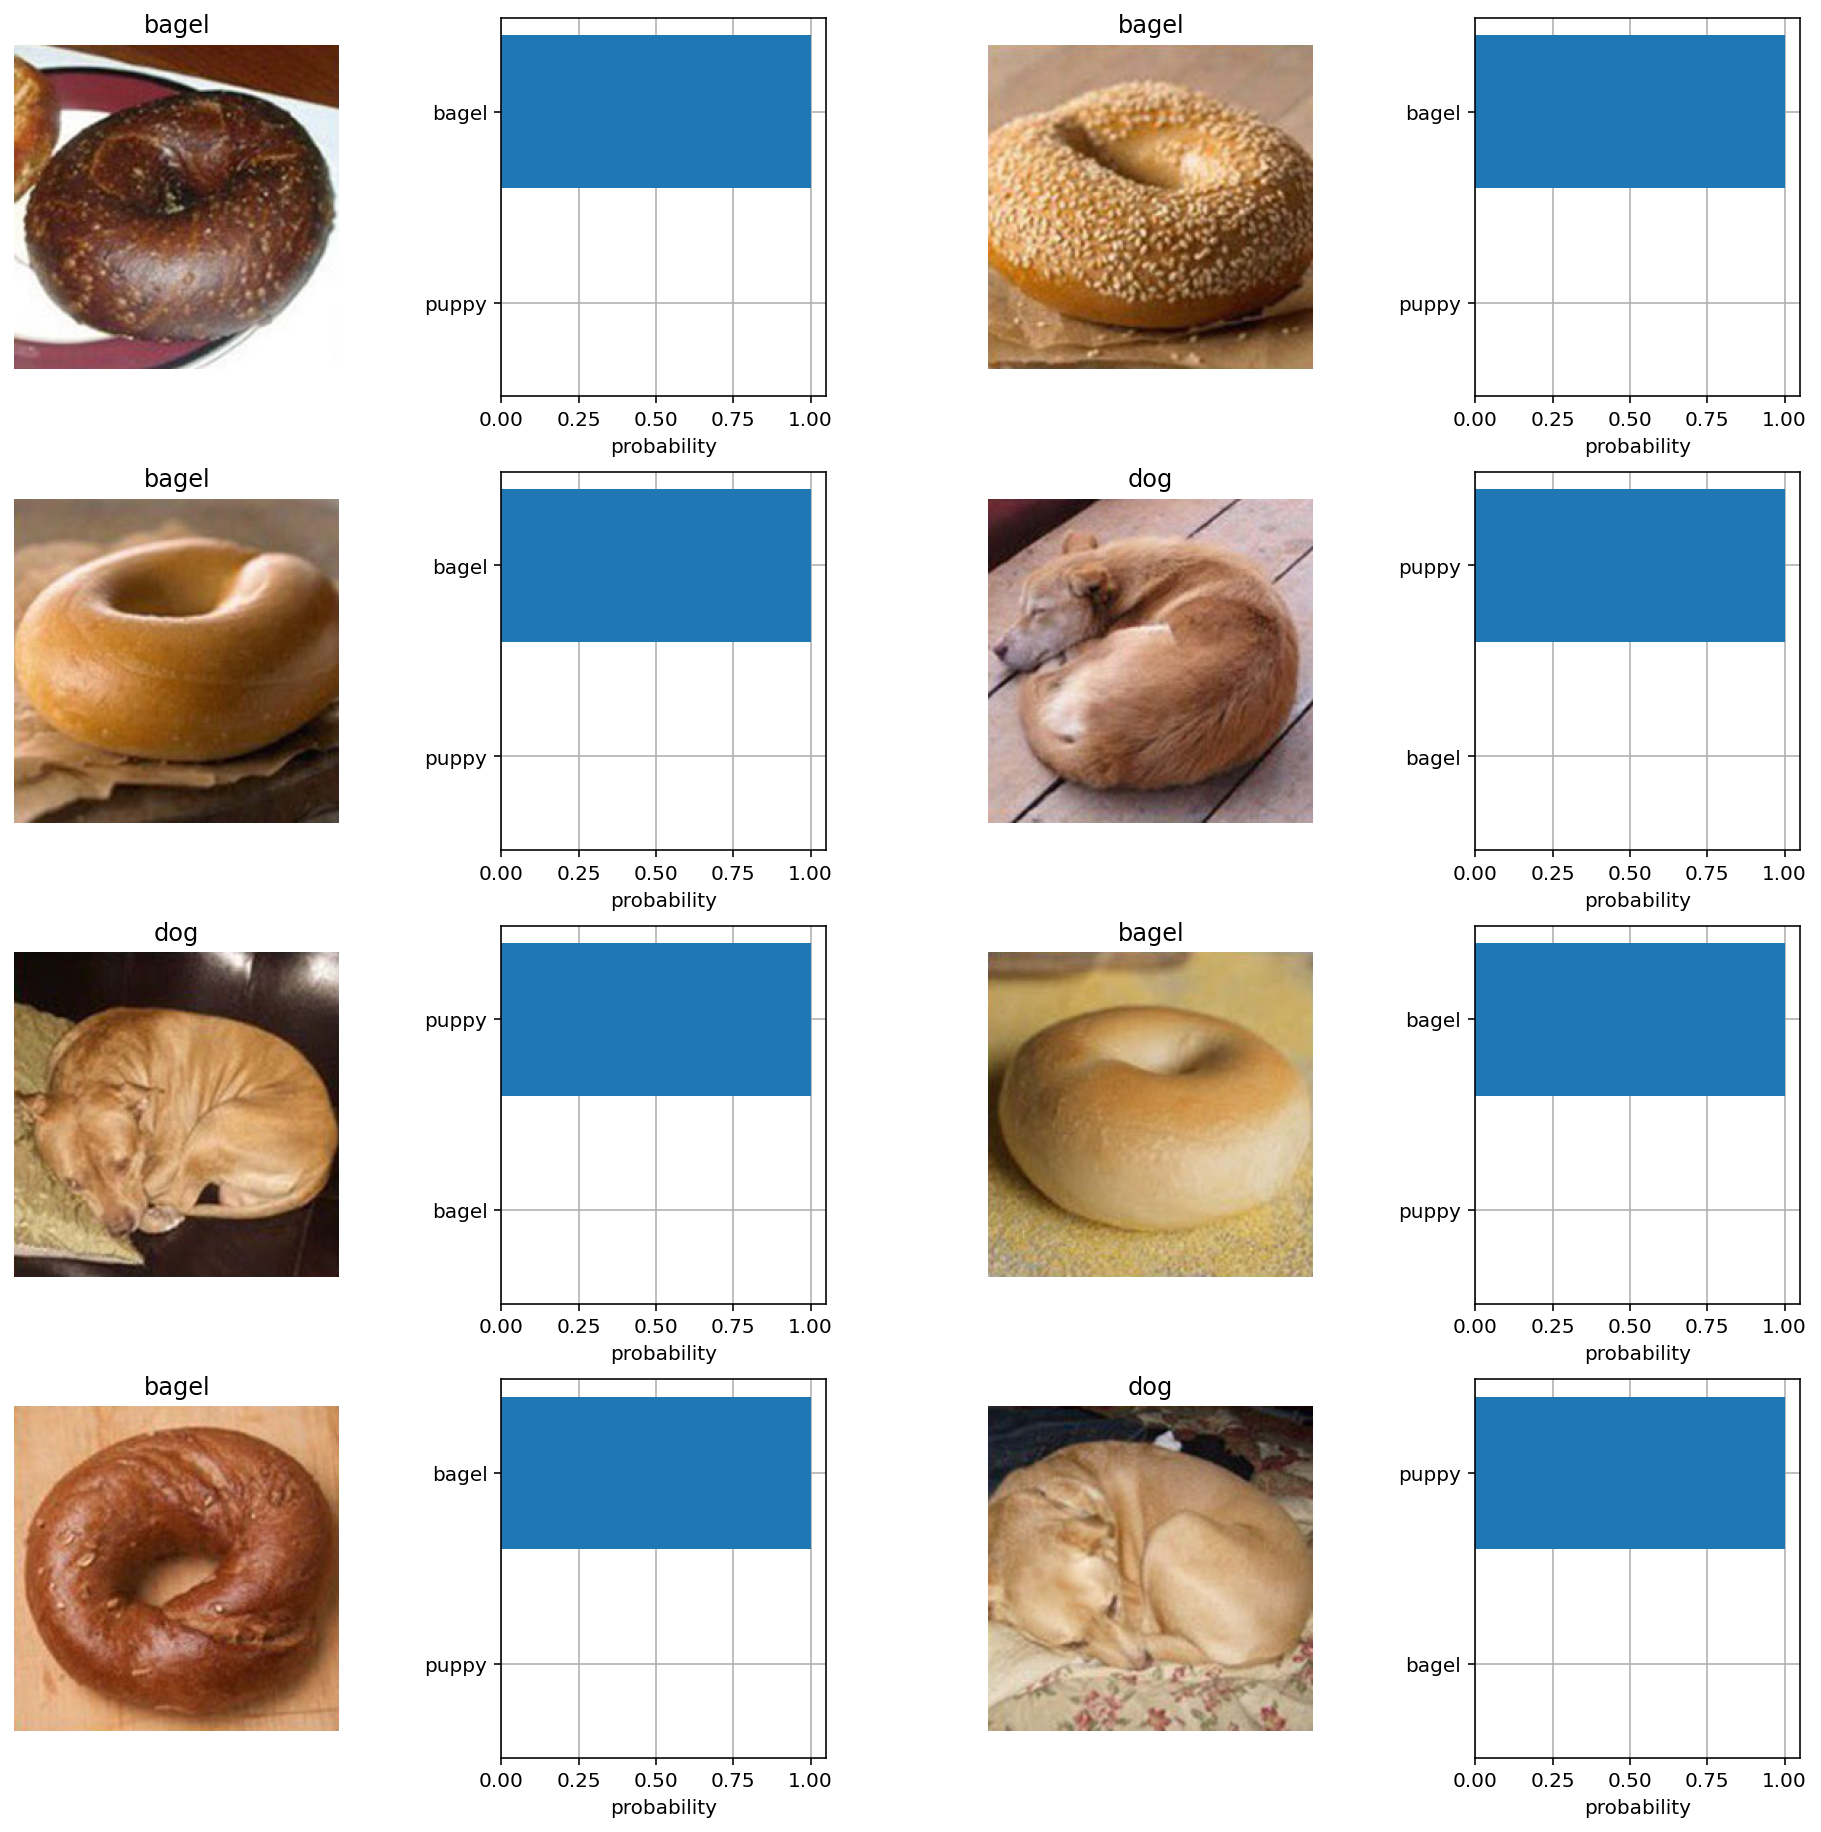

In [37]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(images_pup_or_bag[8:16]):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.axis("off")
    plt.title(texts_pup_or_bag[i + 8])

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i + 8])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [classes[index] for index in top_labels[i + 8].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.savefig('testhotdog7.png')